## Linear Regression Model Using Facebook Prophet 


대회 예측용 코드 

#### Preproess
- 2018.06.01 ~ 2019.02.28까지의 transaction data
- 음값의 amount를 가지는 transaction 존재
    - 카드거래 취소 적용한 data_pos.csv 사용
- 거래 단위의 train data를 2주 단위로 샘플링
    - 예측값으로 6*2주치 데이터의 합을 사용
    
#### Model Construction
1. store_id마다 Prophet model 생성 후 피팅
2. future Dataframe 생성
3. future data와 input data 사이의 피팅률 확인
4. 피팅이 잘된 경우 6개의 fruture prediction 값의 합을 반환
5. 피팅이 잘안된 경우 파라미터 조정 후 1을 반복
   
#### Parameters

- 샘플링 관련
    - sampling_period_days : __14__, 28
    - make_future : __`(periods=6,freq='2W')`__ , `(preiods=3, freq='M')`
- 트랜드 관련
    - changepoint_range : 기본 0.8
    - changepoint_prior_scale : 1 클수록 그래프 유연 data가 sparse할 수록 지수함수로 감소
    - MAE기반 피팅 평가함수를 두고 피팅 잘안된경우 cps 10으로 증가
- 피팅 상한 관련
    - cap : 샘플링 이후의 `ts_store.max()`
    - floor : 샘플링 이후의 `ts_store.min()`
    - growth : logistic


In [1]:
import numpy as np
import pandas as pd
from pandas import datetime
import matplotlib.pyplot as plt
from fbprophet import Prophet
import warnings
warnings.filterwarnings(action='ignore')

from datetime import date, timedelta
from lunarcalendar import Lunar, Converter
print("done")

done


In [2]:
df = pd.read_csv('data_pos.csv')
print("done")

done


In [3]:
df.transacted_date = pd.to_datetime(df.transacted_date)
test_groupby_date_store = df.groupby(['transacted_date', 'store_id'])['amount'].sum()
test_groupby_date_store = test_groupby_date_store.reset_index()
test_groupby_date_store = test_groupby_date_store.set_index('transacted_date')
store_list = test_groupby_date_store.store_id.unique()
store_list.sort()
print("store list :")
print(store_list)
ts_train = test_groupby_date_store
print("done")

store list :
[   0    1    2 ... 2134 2135 2136]
done


In [5]:
def sampling(input_df, sampling_period_days):
    input_df = input_df[len(input_df) % sampling_period_days:].resample(str(sampling_period_days) + 'D').sum()
    return input_df

In [6]:
ts_train_by_store_2W = {}
ts_train_by_store_1M = {}
i = 0
total = len(store_list)
for store_id in store_list:
    i = i+1
    if i%100 == 0:
        print("{}/{}".format(i,total))
    store_ts = ts_train[ts_train.store_id==store_id]
    store_ts = sampling(store_ts,14)
    ts_train_by_store_2W[store_id] = store_ts
    store_ts = sampling(store_ts,28)
    ts_train_by_store_1M[store_id] = store_ts
print("done")

100/1967
200/1967
300/1967
400/1967
500/1967
600/1967
700/1967
800/1967
900/1967
1000/1967
1100/1967
1200/1967
1300/1967
1400/1967
1500/1967
1600/1967
1700/1967
1800/1967
1900/1967
done


In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.covariance import EllipticEnvelope
from sklearn.datasets import make_blobs


def outlier_detect(data):
    d = [[x] for x in data]
    outlier_detector = EllipticEnvelope(contamination=0.1)
    outlier_detector.fit(d)
    outlier = outlier_detector.predict(d)
    for i in range(len(outlier)):
        if i==-1:
            d[i] = [0]
    mean = np.sum(d)/np.unique(1, return_counts=True)[1]
    for i in range(len(d)):
        if d[i][0]==0:
            d[i] = [mean]
    scaler = MinMaxScaler(feature_range=(0,1))
    return scaler.fit_transform(d)

def get_mae(predict_amount, true_amount):
    try:
        t = outlier_detect(true_amount)
        p = outlier_detect(predict_amount)
    except:
        return 1
    mae = mean_absolute_error(p[:],t[:])
    return mae


def prophet_main(store_id,cps_max):
    store_ts = ts_train_by_store_2W[store_id]
    count_zero = len(store_ts[(store_ts.amount == 0) | (store_ts.amount.isna())])
    cps = max(cps_max*((1 - (count_zero)/len(store_ts)))**2,0.05)
    s_max = store_ts.amount.max(); s_min = store_ts.amount.min()
    store_ts['y'] = store_ts['amount']
    store_ts['ds'] = store_ts.index
    store_ts['cap'] = s_max
    store_ts['floor'] = s_min
    store_ts = store_ts.drop('amount', axis=1)
    store_ts = store_ts.drop('store_id', axis=1) 
    m = Prophet(changepoint_prior_scale=cps,changepoint_range=0.8,growth='logistic')
    m_fit = m.fit(store_ts)
    future = m_fit.make_future_dataframe(periods=6,freq='2W')
    future['cap'] = s_max
    future['floor'] = s_min
    forecast = m_fit.predict(future)
    print("{}/{} store_id: {} cps: {}".format(i,total,store_id,cps))
    size = store_ts.shape[0]
    mae = get_mae(forecast.yhat[:size],store_ts.y)
    if cps_max==1 and  mae > 0.25:
        return None
    else:
        result = np.sum(list(map(lambda x: x if x>s_min else s_min , forecast.yhat[size:])))
        print("result",result)
        return result

store_amount = {}
store_amount['store_id'] = []
store_amount['amount'] = []
i = 0
total = len(store_list)
for store_id in store_list[:]:
    i = i+1
    result = None
    result = prophet_main(store_id,1)
    if result == None:
        result = prophet_main(store_id,10)
    store_amount['store_id'].append(store_id)
    store_amount['amount'].append(result)


In [46]:
out_ff = pd.DataFrame(store_amount,columns=['store_id','amount'])  
print(out_ff)
out_ff.to_csv("result/prophet2W6P-CPS10to1-logistic.csv", mode='w',index=False) # 새파일로 덮어쓰기

      store_id        amount
0            0  1.725895e+06
1            1  2.568063e+05
2            2  9.091995e+05
3            4  2.253988e+06
4            5  8.263318e+05
5            6  5.325936e+06
6            7  5.191895e+05
7            8  3.940355e+06
8            9  1.586164e+06
9           10  1.641086e+06
10          11  1.678630e+06
11          12  1.162214e+06
12          13  1.824005e+06
13          14  1.024035e+07
14          15  2.013680e+06
15          16  4.891949e+05
16          17  5.817783e+05
17          18  1.093145e+06
18          19  4.835370e+06
19          20  5.997810e+06
20          22  5.165009e+05
21          23  2.147245e+06
22          24  7.726610e+06
23          25  4.659783e+05
24          26  4.251018e+05
25          27  6.307029e+06
26          28  3.307937e+06
27          29  2.077900e+06
28          30  7.990425e+05
29          31  1.828529e+06
...        ...           ...
1937      2106  3.535272e+06
1938      2107  3.061234e+05
1939      2108

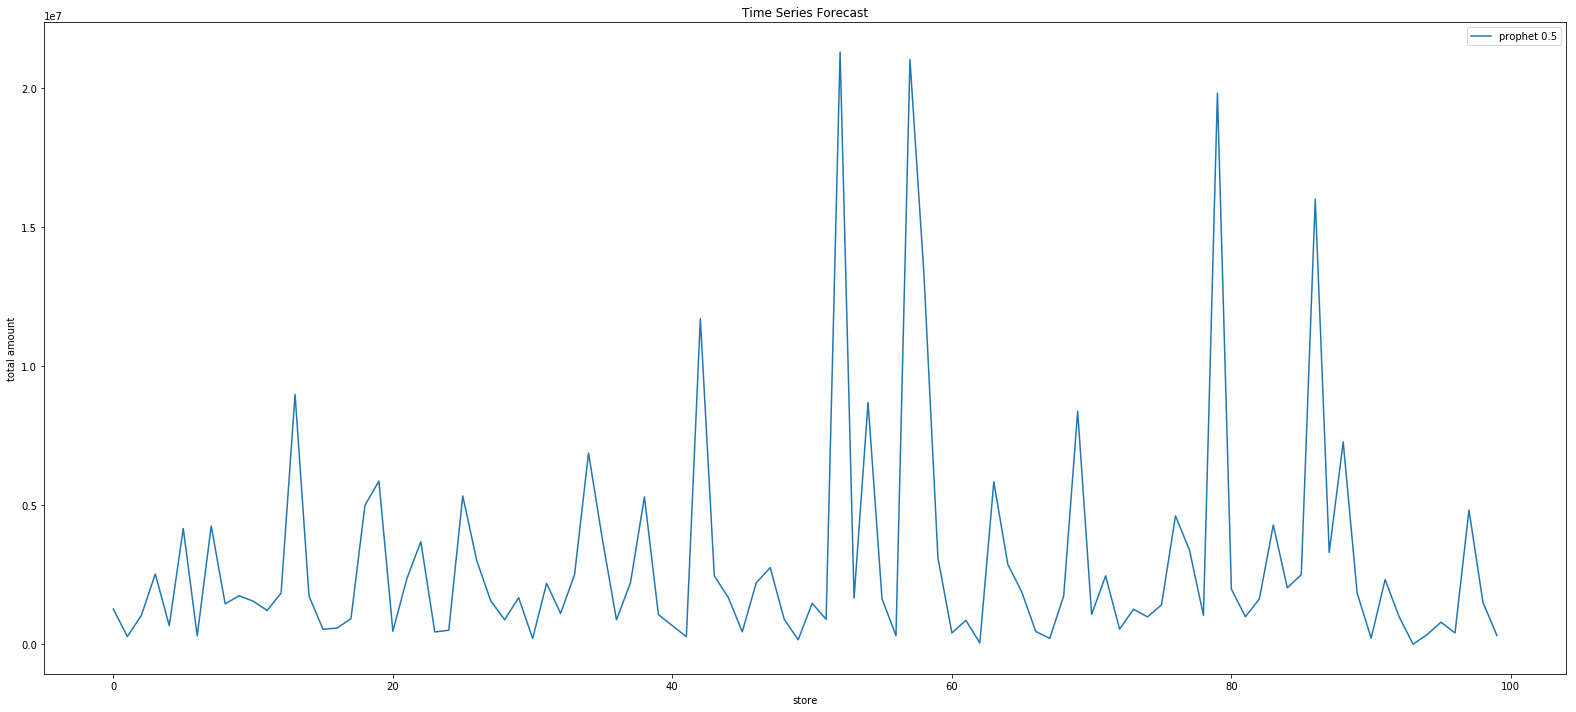

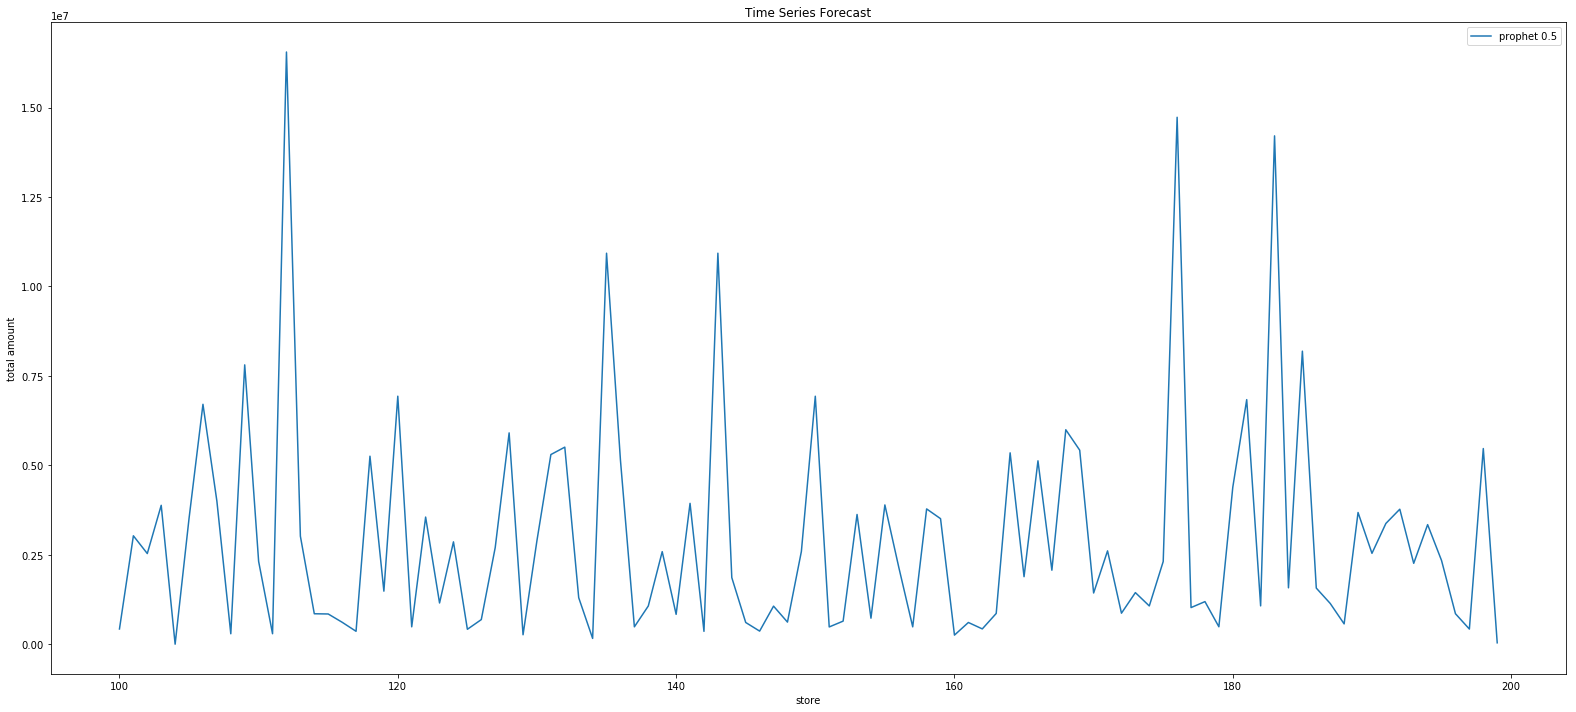

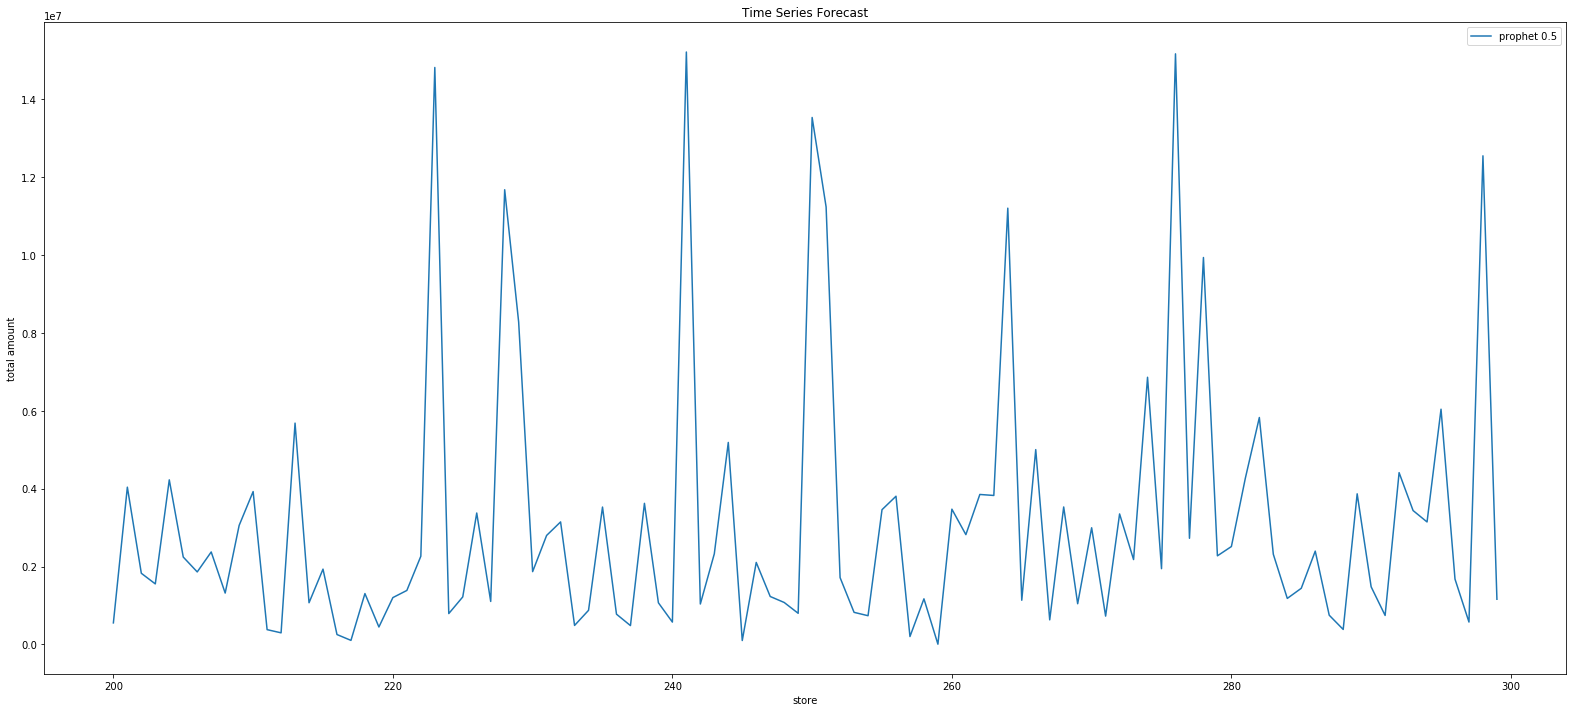

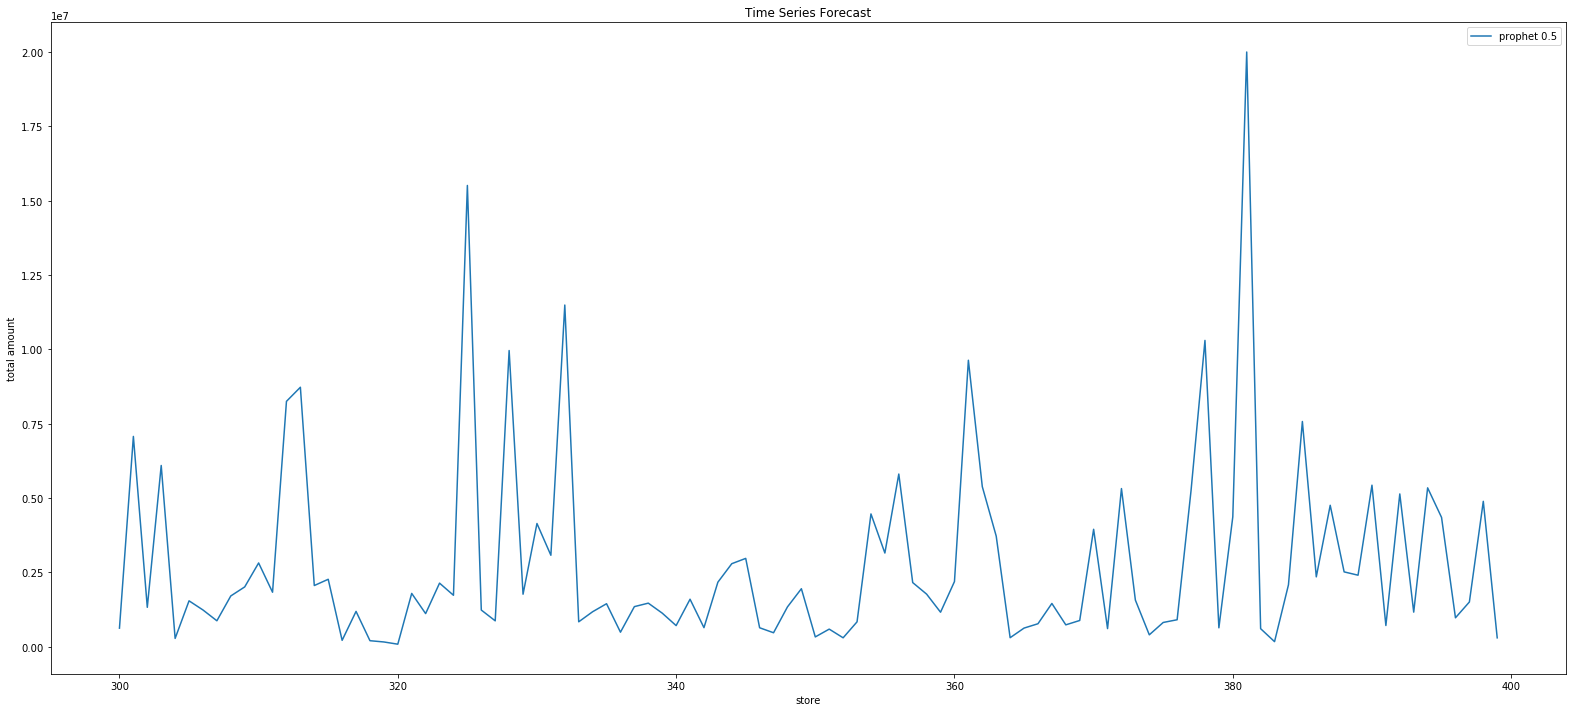

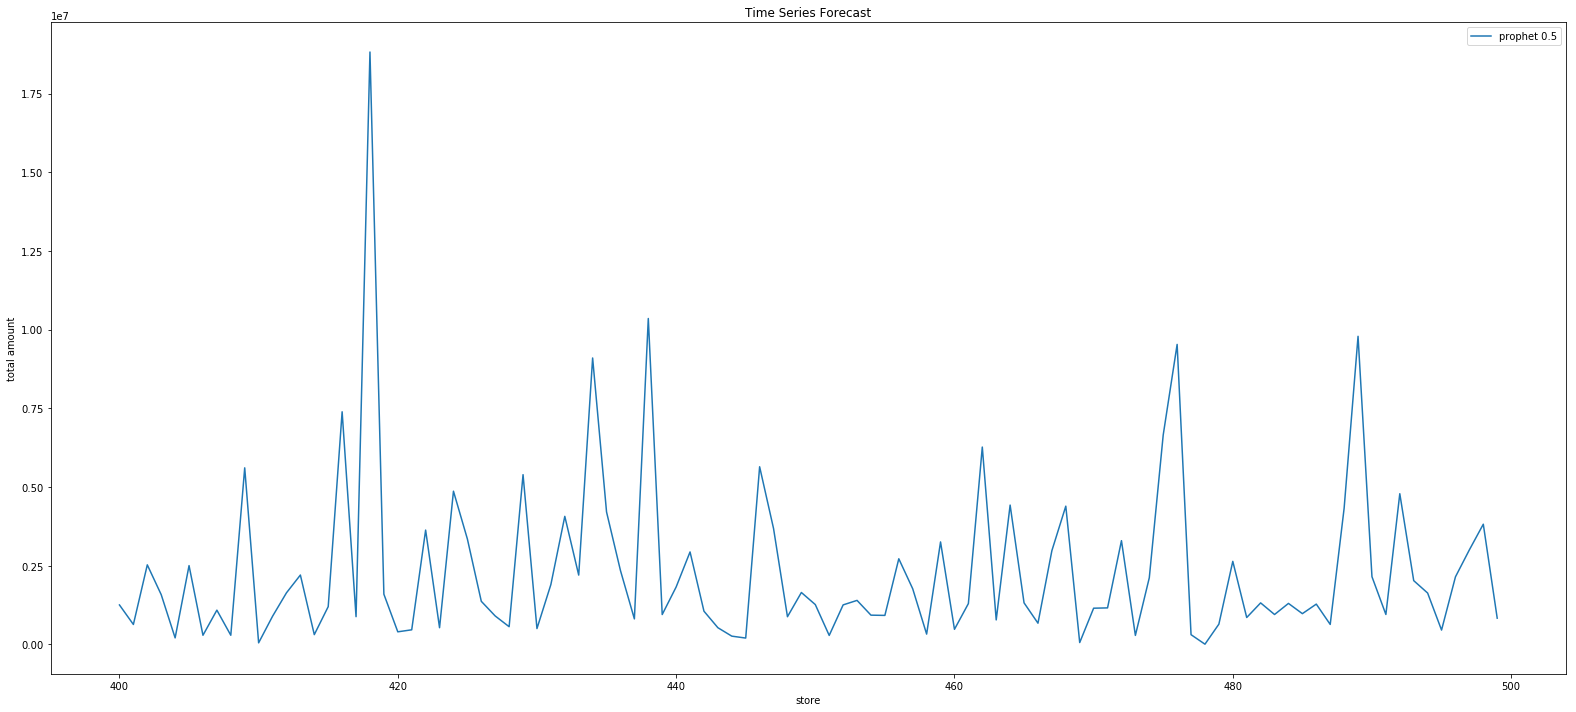

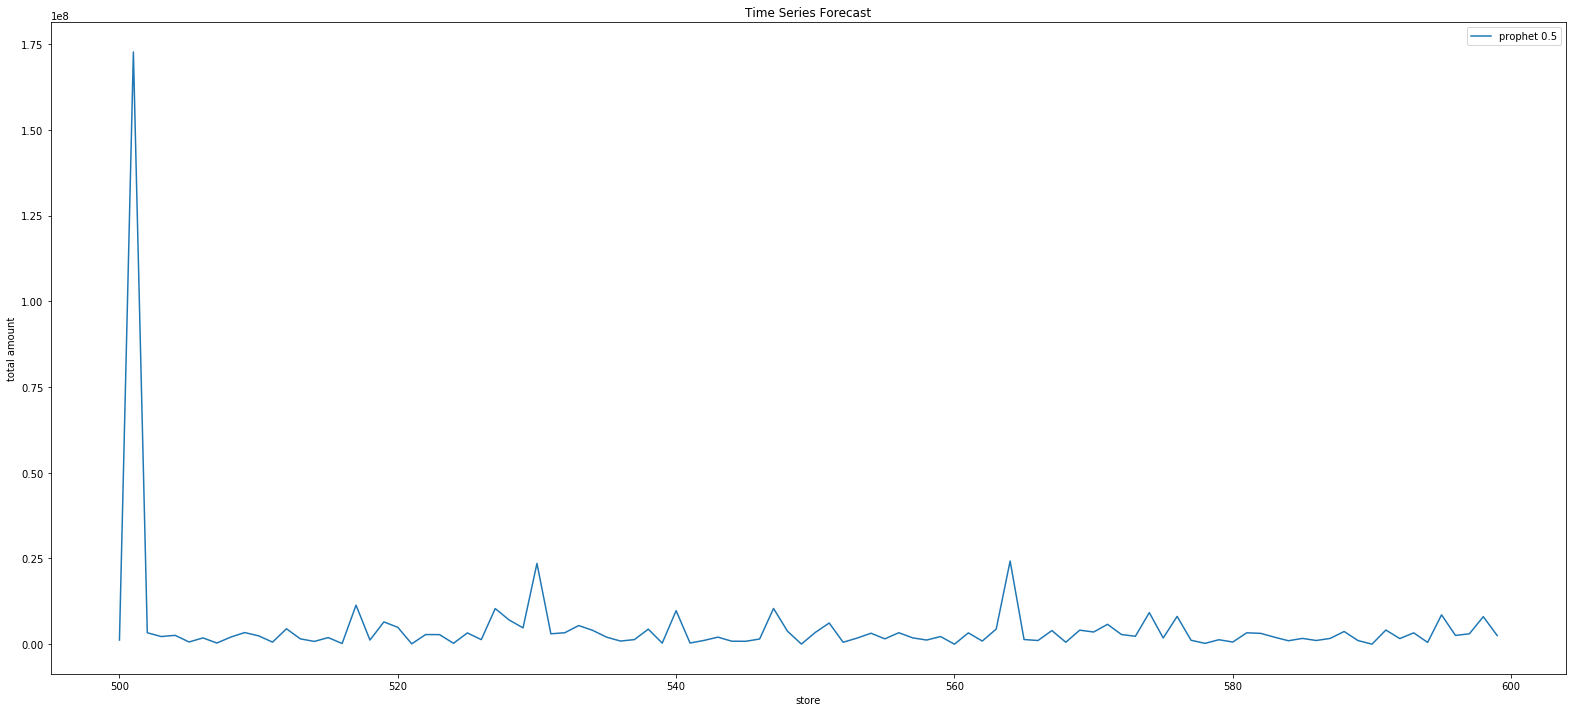

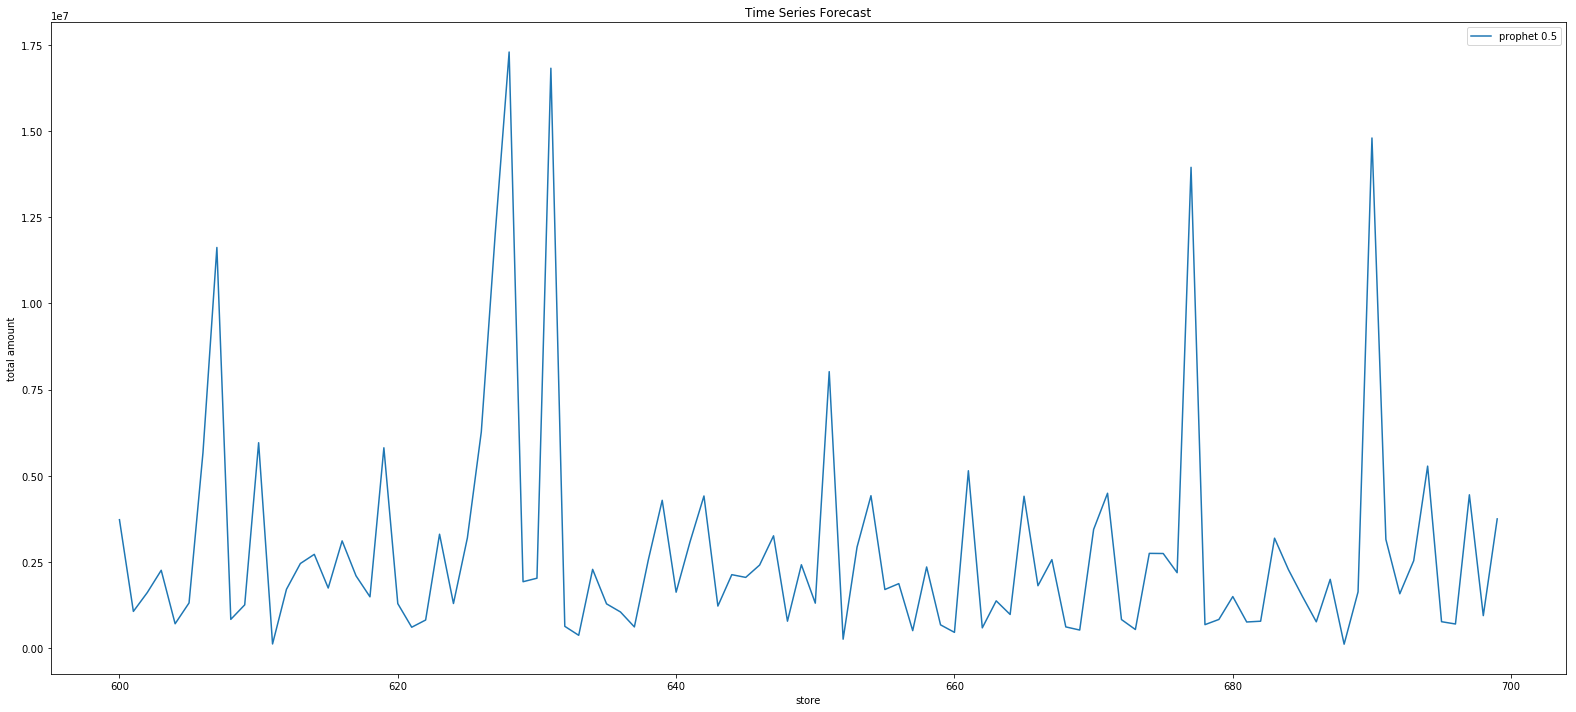

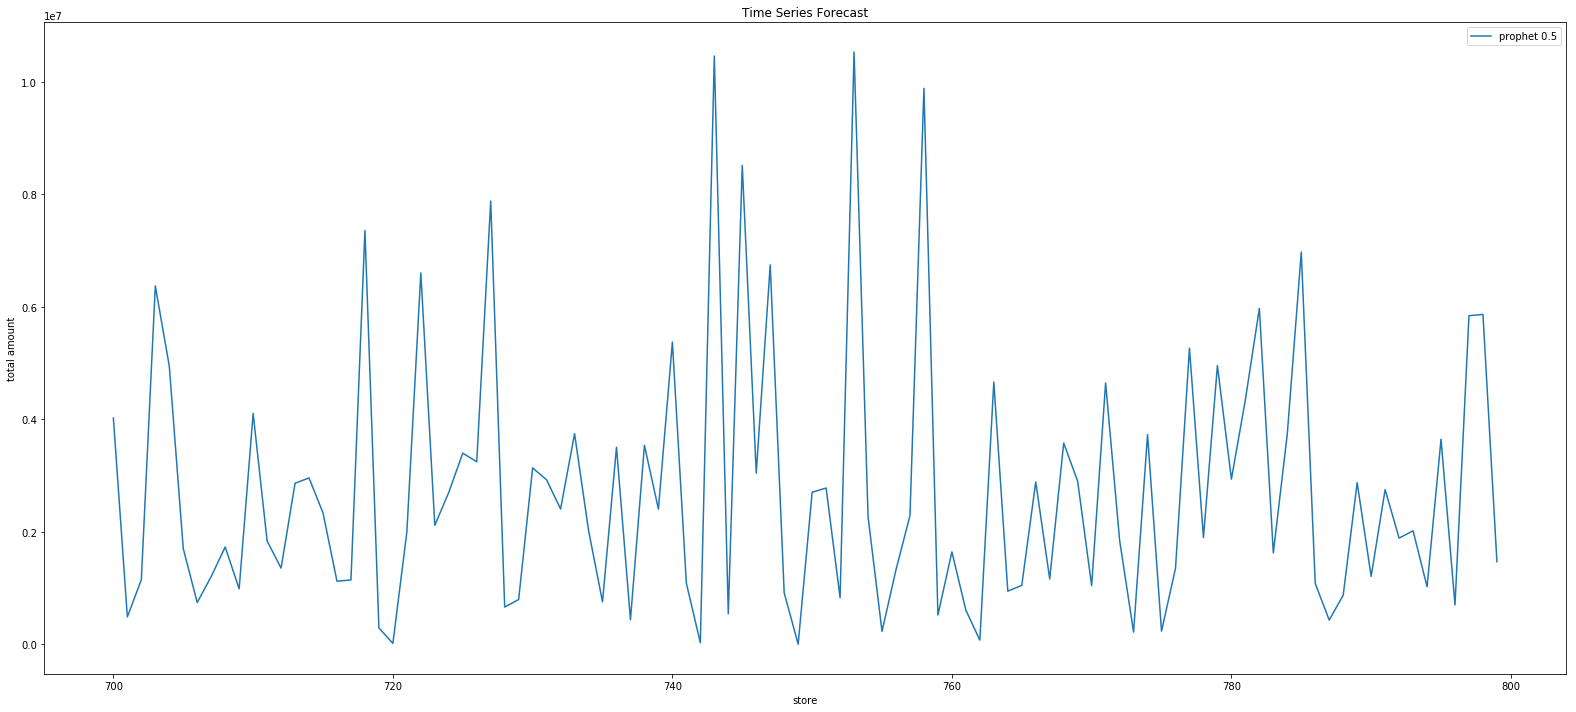

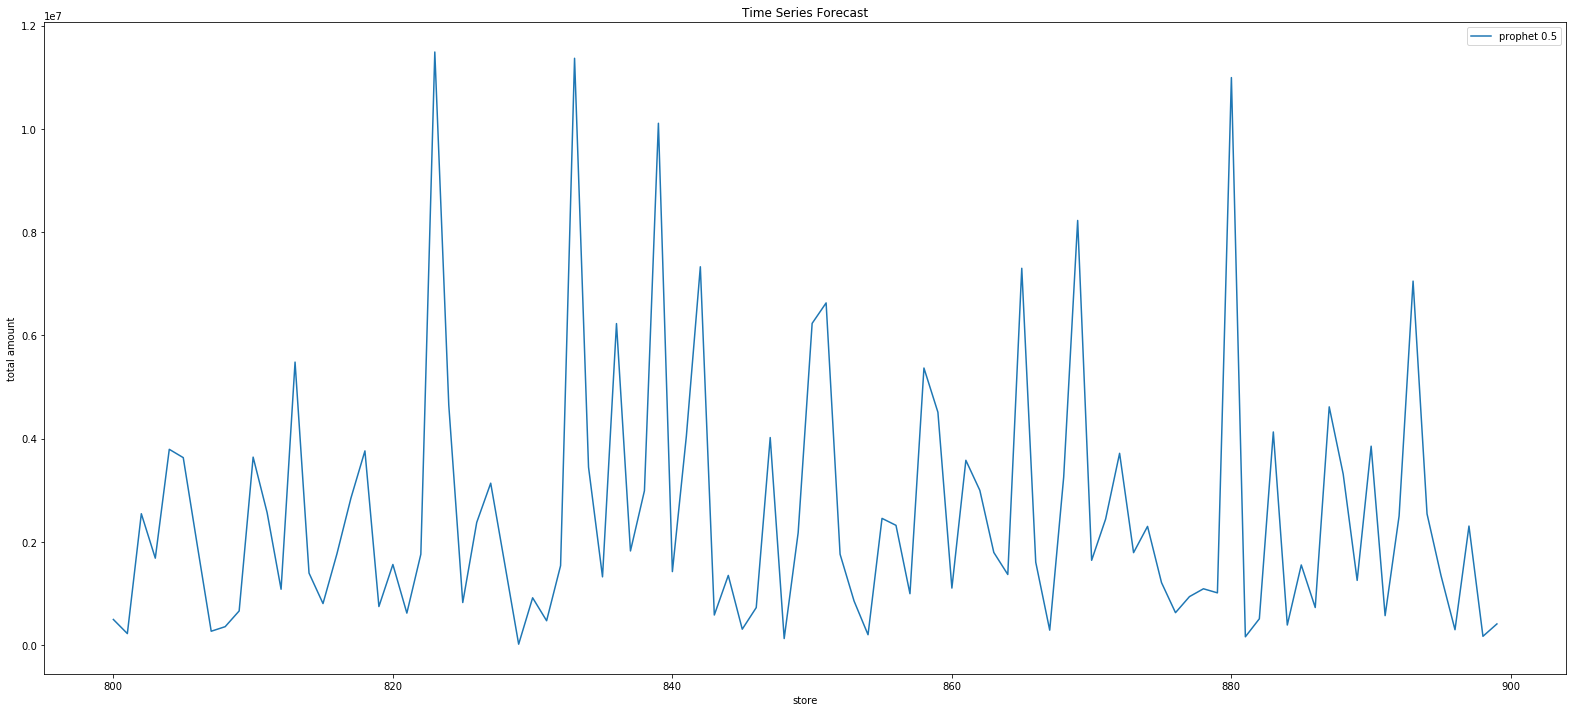

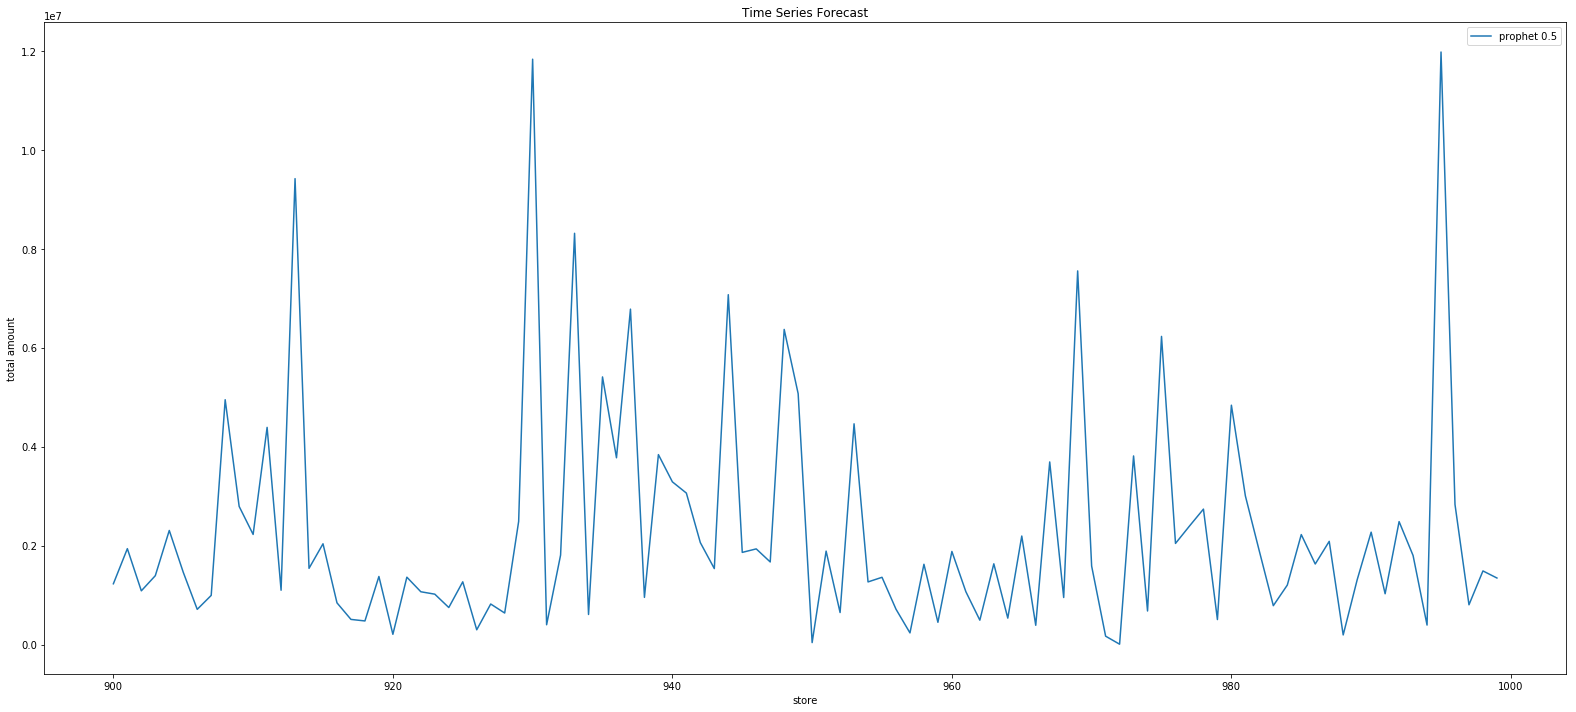

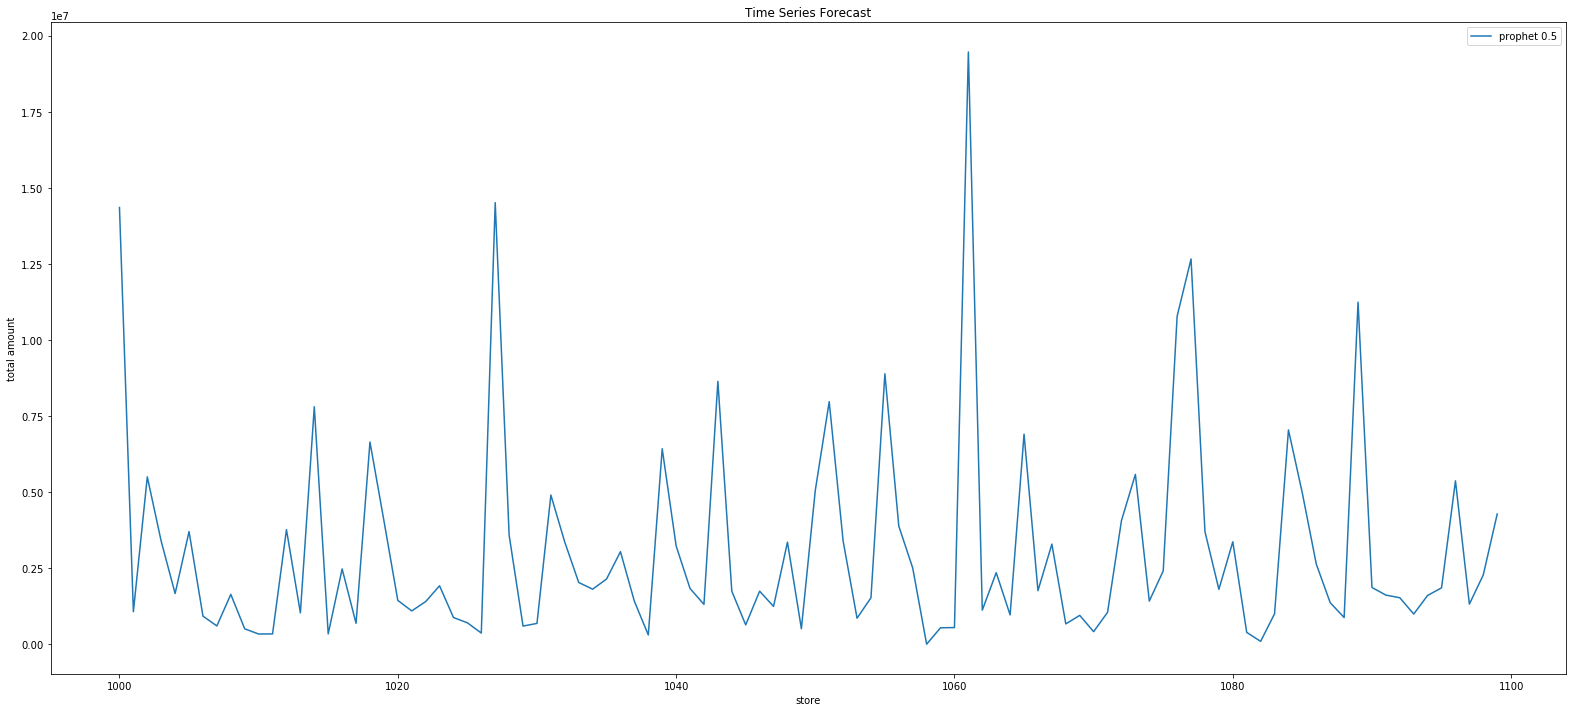

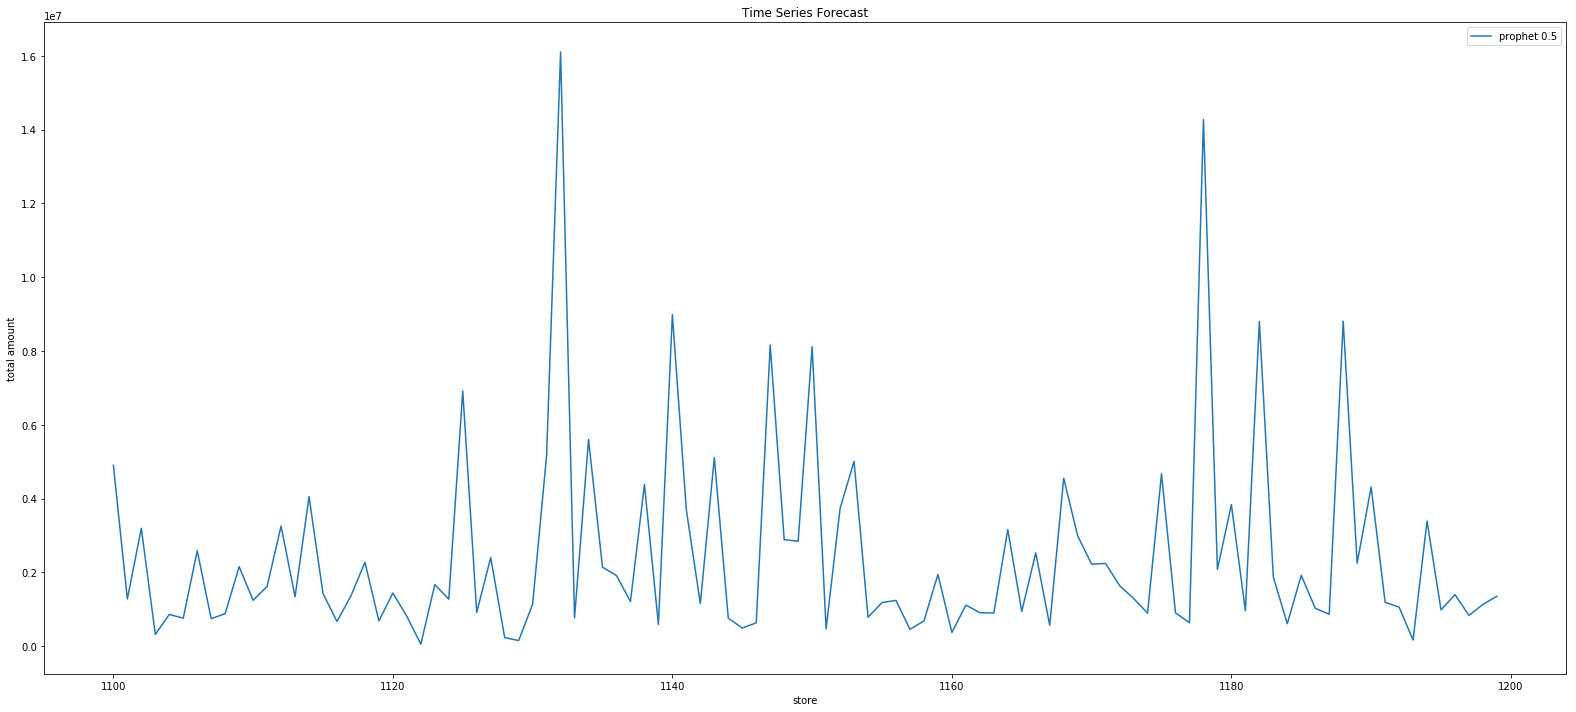

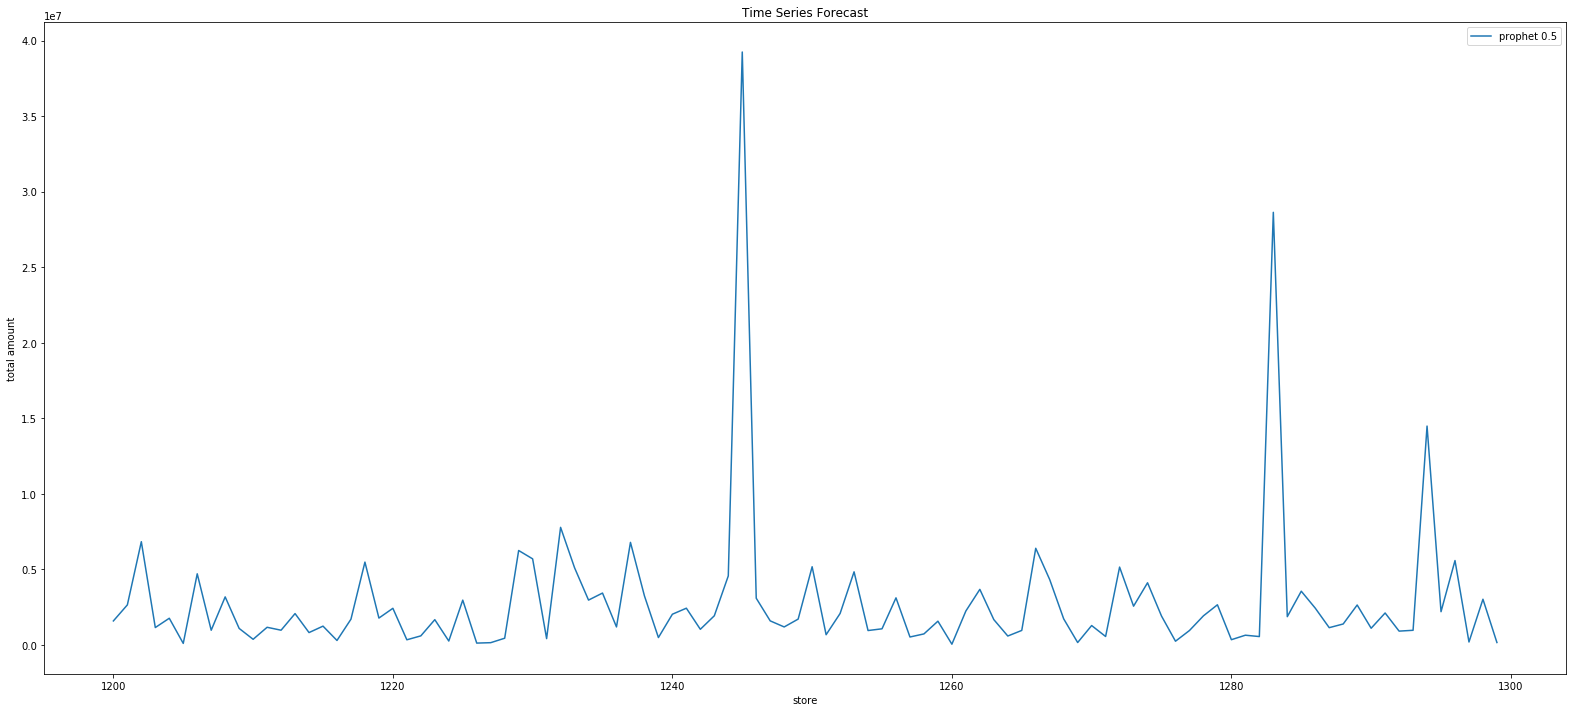

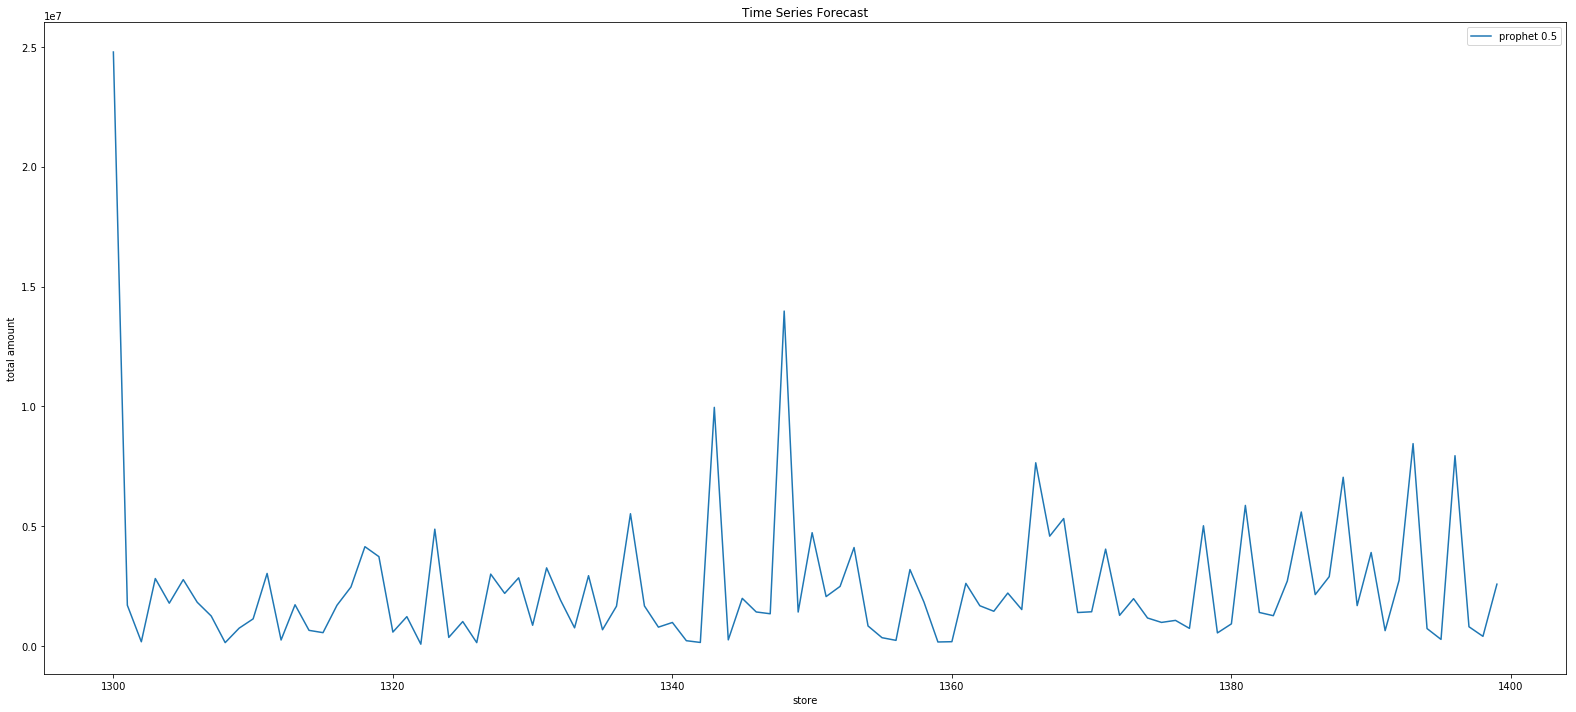

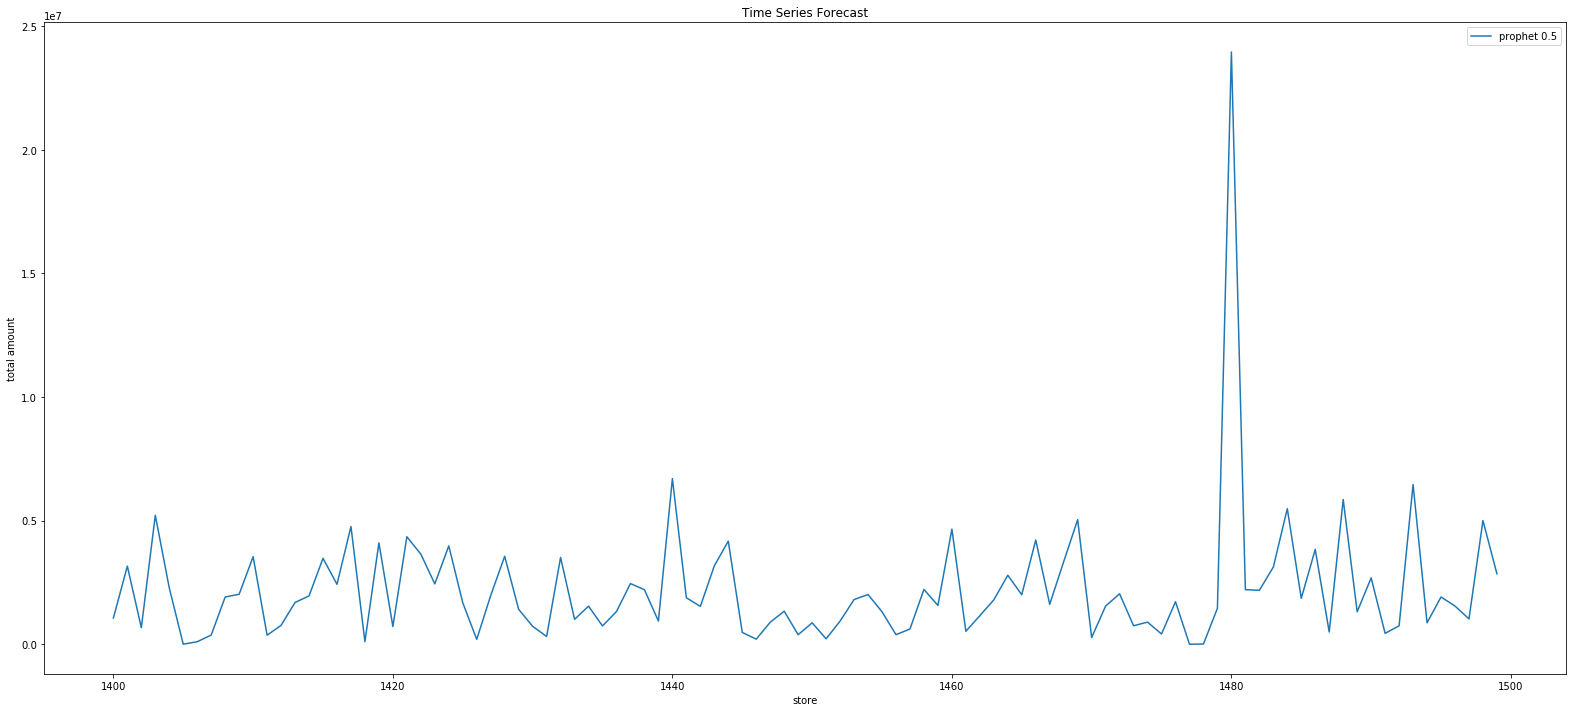

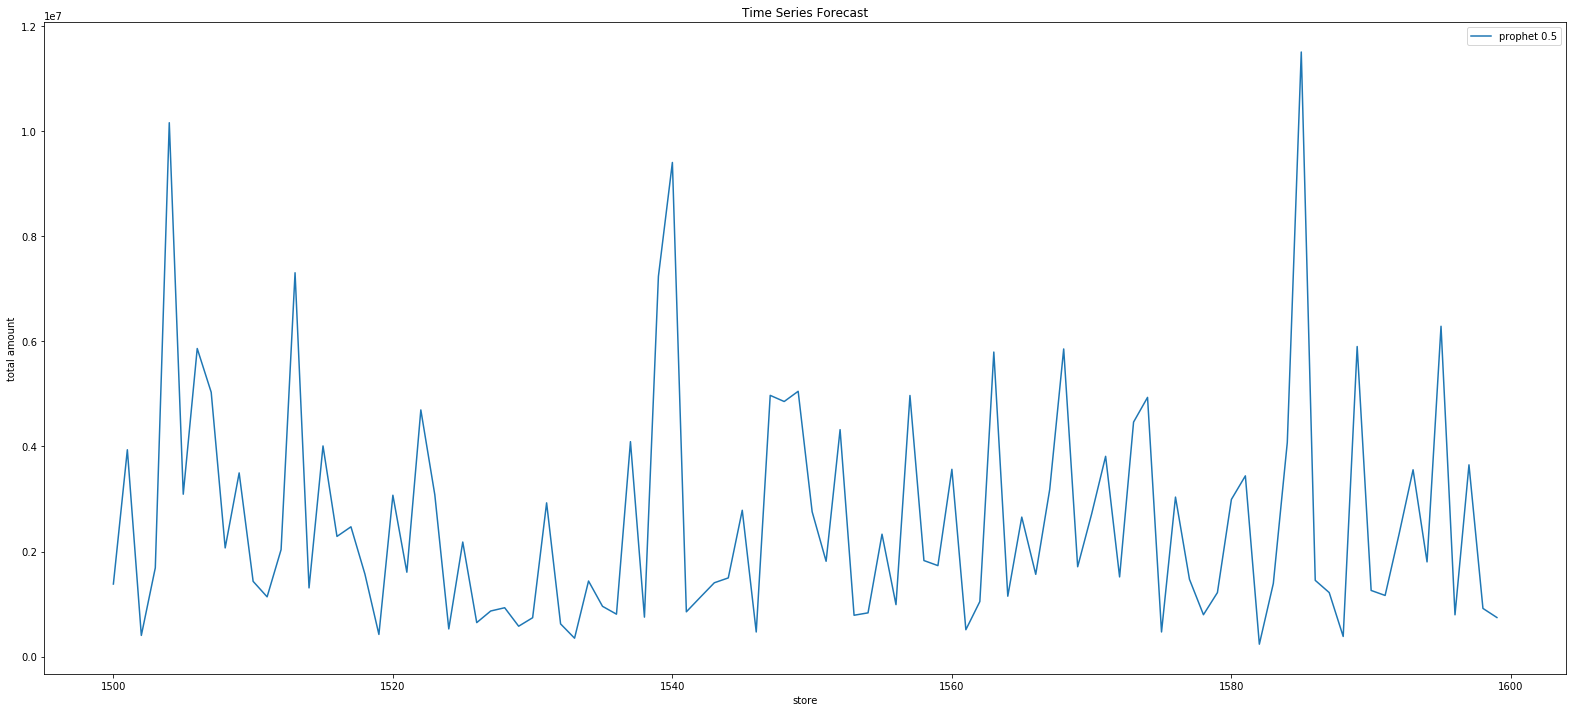

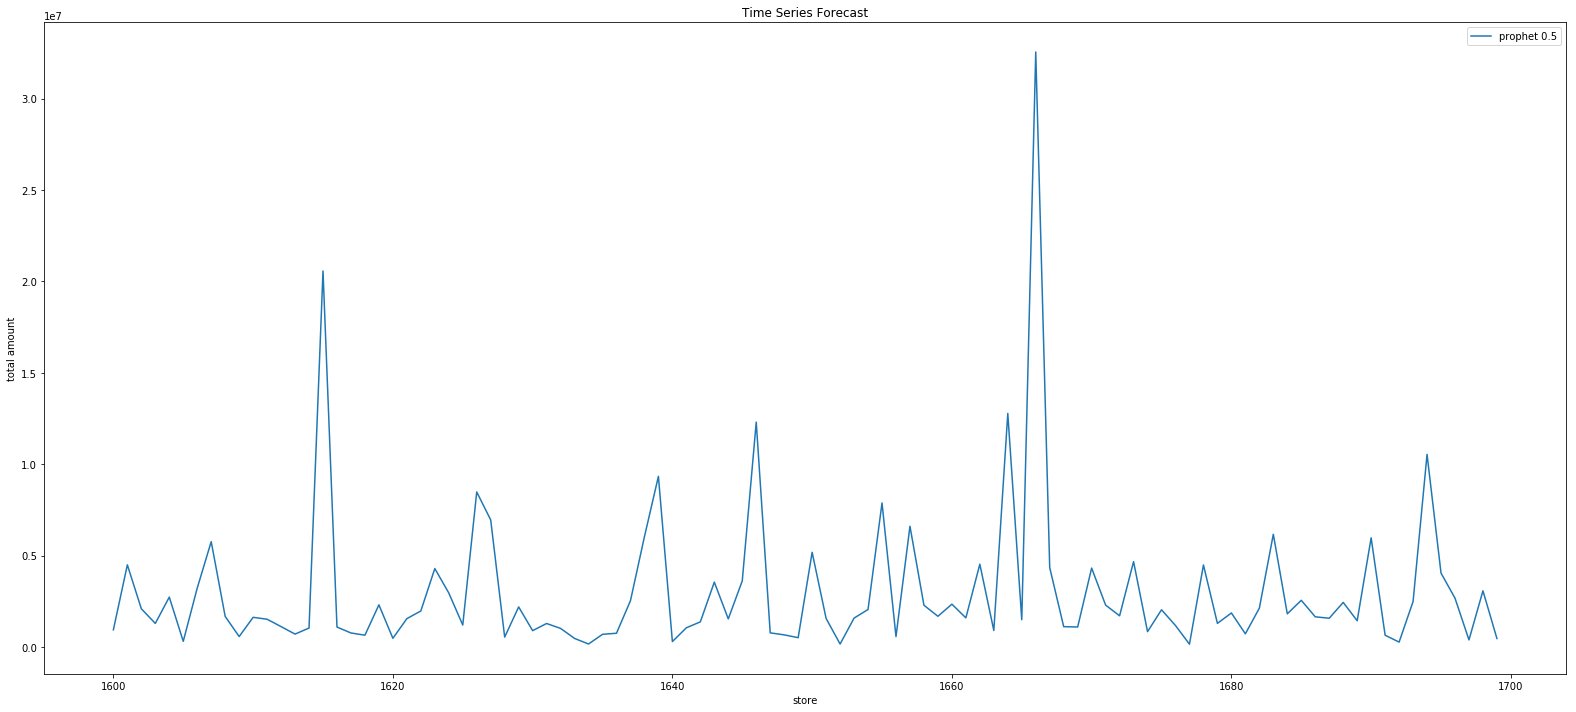

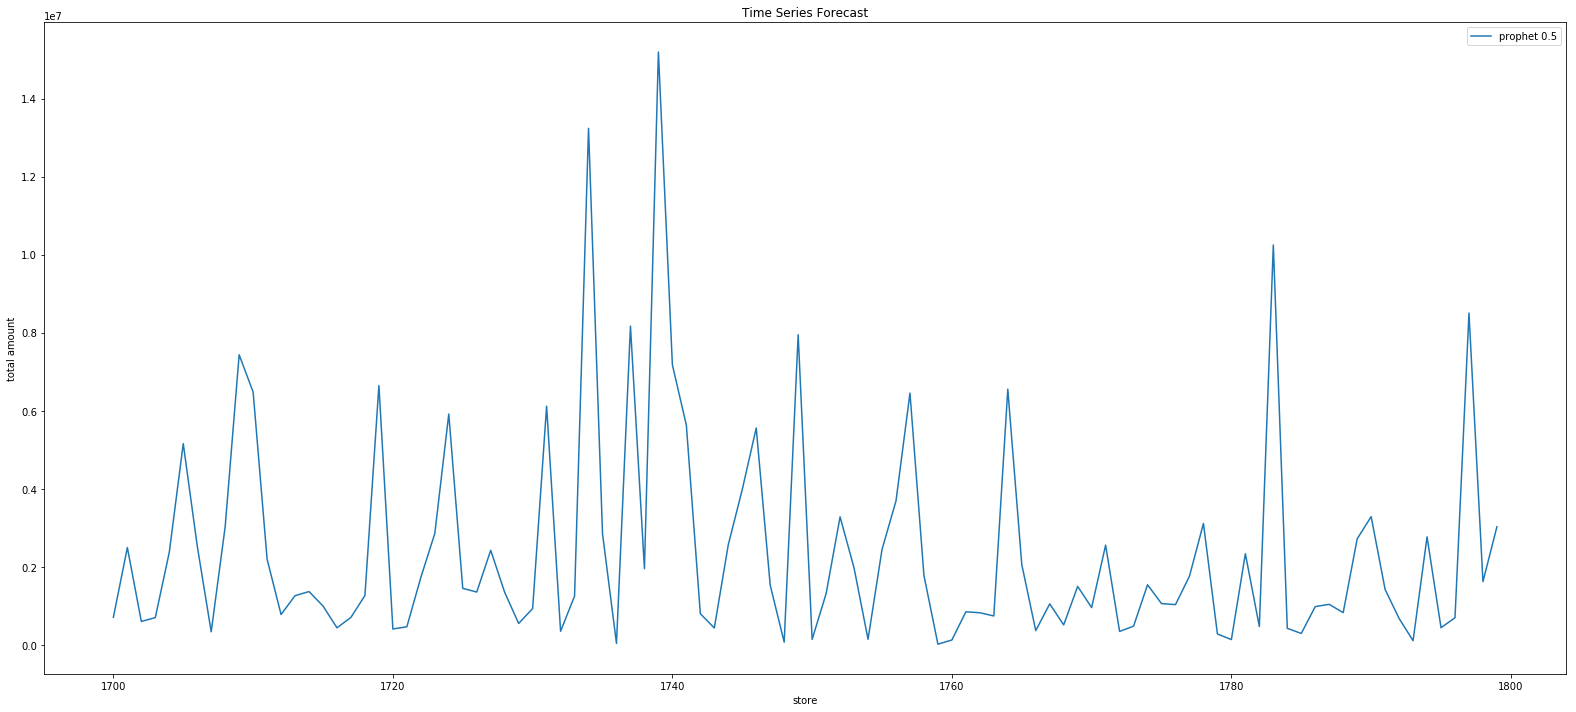

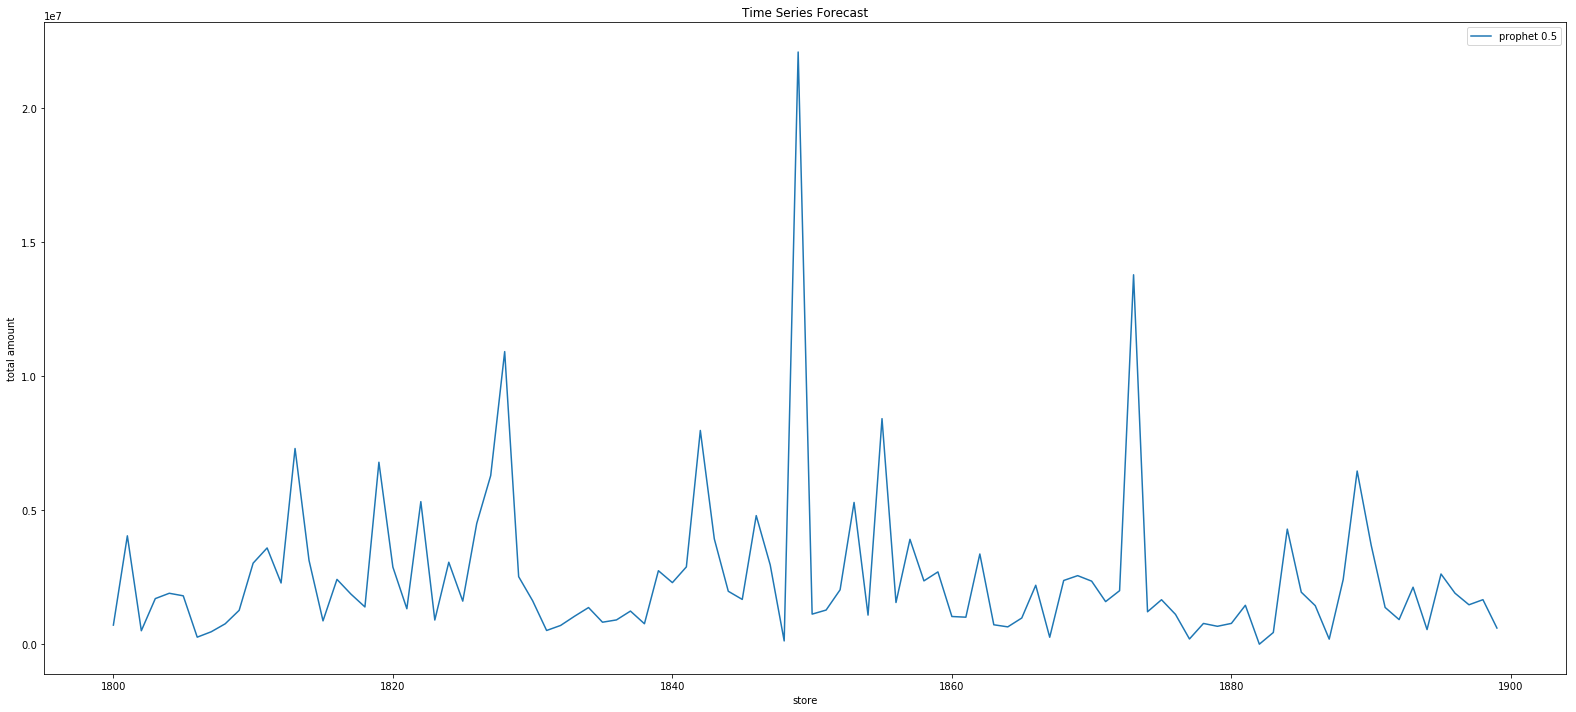

In [35]:
for i in np.arange(0,1900,100):
    
    start = i
    end = i+ 100

    plt.figure(figsize=(22,10))
    plt.plot(out_ff.amount[start:end],label = "prophet")
    plt.title("Time Series Forecast")
    plt.xlabel("store")
    plt.ylabel("total amount")
    plt.legend()
    plt.tight_layout()
    plt.show()